In [181]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parámetros del entorno
MAX_STATE = 10           # Escala de 0 a 10 para C1 y C2
LAMBDA_ARRIVAL_C1 = 4       # Parámetro de la distribución de Poisson para llegadas
LAMBDA_ARRIVAL_C2 = 2       # Parámetro de la distribución de Poisson para llegadas

# Parámetros de Q-Learning
ALPHA = 0.1              # Tasa de aprendizaje
GAMMA = 0.95             # Factor de descuento
EPSILON = 1.0            # Tasa de exploración inicial
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
NUM_EPISODES = 10001
STEPS_PER_EPISODE = 50

In [182]:
# Definición de las tres acciones:
# Cada acción define en cuánto se reduce la congestión actual en cada carril.
actions = {
    0: {'C1_reduction': 8, 'C2_reduction': 2},  # Prioriza C1
    1: {'C1_reduction': 2, 'C2_reduction': 8},  # Prioriza C2
    2: {'C1_reduction': 4, 'C2_reduction': 4},  # Equilibrado
}

# Función de recompensa dinámica según el nivel de congestión
def compute_reward(c1, c2):
    # Si ambos carriles están en estado de "baja congestión"
    if c1 <= 7 and c2 <= 7:
        return -(c1 + c2)
    # Si C1 está congestionado (mayor a 7) y es el que tiene mayor o igual congestión
    elif c1 > 7 and c1 >= c2:
        return -(2 * c1 + 1 * c2)
    # Si C2 está congestionado (mayor a 7) y es el que tiene mayor congestión
    elif c2 > 7 and c2 > c1:
        return -(1 * c1 + 2 * c2)
    else:
        return -(c1 + c2)
    
    
def compute_reward(c1, c2):
    return -(c1 + c2)

# Definición del entorno
class TrafficEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        # Estado inicial: congestion en C1 y C2 (valores bajos)
        self.c1 = random.randint(0, 3)
        self.c2 = random.randint(0, 3)
        return (self.c1, self.c2)

    def step(self, action):
        # Aplicar efecto de la acción: reducir congestión sin bajar de cero
        reduction = actions[action]
        self.c1 = max(self.c1 - reduction['C1_reduction'], 0)
        self.c2 = max(self.c2 - reduction['C2_reduction'], 0)
        
        # Llegadas de nuevos vehículos según distribución de Poisson
        arrival_c1 = np.random.poisson(LAMBDA_ARRIVAL_C1)
        arrival_c2 = np.random.poisson(LAMBDA_ARRIVAL_C2)
        self.c1 = min(self.c1 + arrival_c1, MAX_STATE)
        self.c2 = min(self.c2 + arrival_c2, MAX_STATE)
        
        # Calcular la recompensa en función del estado actualizado
        reward = compute_reward(self.c1, self.c2)
        next_state = (self.c1, self.c2)
        done = False  # En este ejemplo, cada episodio tiene un número fijo de pasos
        return next_state, reward, done

Episode 0: Total reward = -11.36
Episode 500: Total reward = -11.88
Episode 1000: Total reward = -11.7
Episode 1500: Total reward = -11.68
Episode 2000: Total reward = -11.6
Episode 2500: Total reward = -11.9
Episode 3000: Total reward = -11.24
Episode 3500: Total reward = -11.68
Episode 4000: Total reward = -11.66
Episode 4500: Total reward = -11.42
Episode 5000: Total reward = -11.44
Episode 5500: Total reward = -11.72
Episode 6000: Total reward = -11.46
Episode 6500: Total reward = -11.66
Episode 7000: Total reward = -11.3
Episode 7500: Total reward = -11.34
Episode 8000: Total reward = -11.96
Episode 8500: Total reward = -12.02
Episode 9000: Total reward = -11.42
Episode 9500: Total reward = -11.76
Episode 10000: Total reward = -11.76


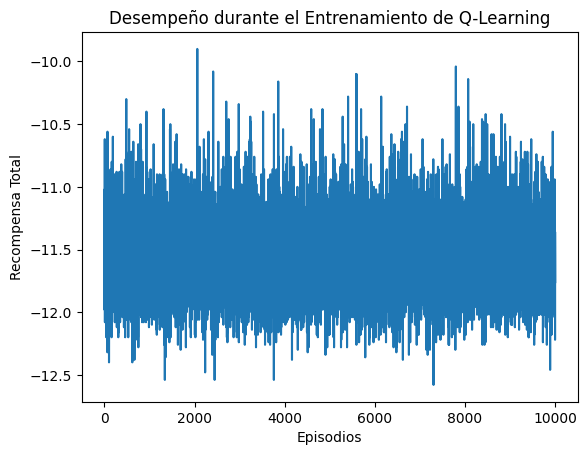

In [183]:
# Baseline always choose the same action:

# Inicialización de la tabla Q
q_table = np.zeros((MAX_STATE + 1, MAX_STATE + 1, len(actions)))

def choose_action(state, epsilon):
    c1, c2 = state
    if random.random() < epsilon:
        return random.randint(0, len(actions)-1)  # Exploración
    else:
        return np.argmax(q_table[c1, c2, :])      # Explotación

# Bucle de entrenamiento
env = TrafficEnv()
rewards_per_episode = []
epsilon = EPSILON

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = 1
        next_state, reward, done = env.step(action)
        c1, c2 = state
        next_c1, next_c2 = next_state
        
        # Actualización Q-Learning (Ecuación de Bellman)
        best_next = np.max(q_table[next_c1, next_c2, :])
        q_table[c1, c2, action] += ALPHA * (reward + GAMMA * best_next - q_table[c1, c2, action])
        
        state = next_state
        total_reward += reward
        
    # Decaimiento de epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
    rewards_per_episode.append(total_reward/STEPS_PER_EPISODE)
    
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward/STEPS_PER_EPISODE}")

# Graficar el desempeño del agente durante el entrenamiento
plt.plot(rewards_per_episode)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Total")
plt.title("Desempeño durante el Entrenamiento de Q-Learning")
plt.show()


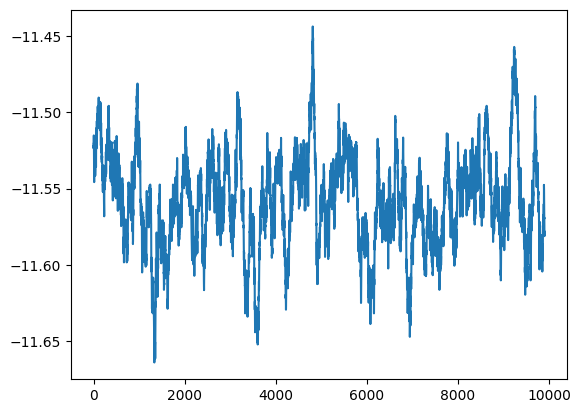

In [184]:
#plot moving average of rewards
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(rewards_per_episode, 100))

Episode 0: Total reward = -8.48
Episode 500: Total reward = -7.04
Episode 1000: Total reward = -6.3
Episode 1500: Total reward = -6.78
Episode 2000: Total reward = -5.82
Episode 2500: Total reward = -7.62
Episode 3000: Total reward = -5.7
Episode 3500: Total reward = -5.78
Episode 4000: Total reward = -5.56
Episode 4500: Total reward = -5.78
Episode 5000: Total reward = -6.42
Episode 5500: Total reward = -6.02
Episode 6000: Total reward = -5.98
Episode 6500: Total reward = -6.14
Episode 7000: Total reward = -6.64
Episode 7500: Total reward = -5.82
Episode 8000: Total reward = -6.94
Episode 8500: Total reward = -5.82
Episode 9000: Total reward = -6.04
Episode 9500: Total reward = -6.9
Episode 10000: Total reward = -6.1


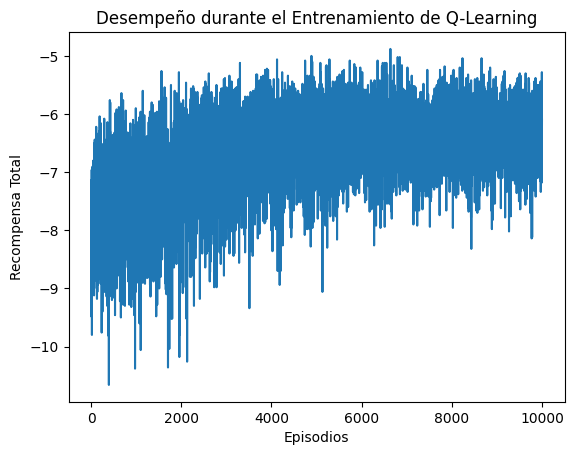

In [185]:
# Inicialización de la tabla Q|
q_table = np.zeros((MAX_STATE + 1, MAX_STATE + 1, len(actions)))

def choose_action(state, epsilon):
    c1, c2 = state
    if random.random() < epsilon:
        return random.randint(0, len(actions)-1)  # Exploración
    else:
        return np.argmax(q_table[c1, c2, :])      # Explotación

# Bucle de entrenamiento
env = TrafficEnv()
rewards_per_episode = []
epsilon = EPSILON

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = choose_action(state, epsilon)
        next_state, reward, done = env.step(action)
        c1, c2 = state
        next_c1, next_c2 = next_state
        
        # Actualización Q-Learning (Ecuación de Bellman)
        best_next = np.max(q_table[next_c1, next_c2, :])
        q_table[c1, c2, action] += ALPHA * (reward + GAMMA * best_next - q_table[c1, c2, action])
        
        state = next_state
        total_reward += reward
        
    # Decaimiento de epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
    rewards_per_episode.append(total_reward/STEPS_PER_EPISODE)
    
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward/STEPS_PER_EPISODE}")

# Graficar el desempeño del agente durante el entrenamiento
plt.plot(rewards_per_episode)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Total")
plt.title("Desempeño durante el Entrenamiento de Q-Learning")
plt.show()


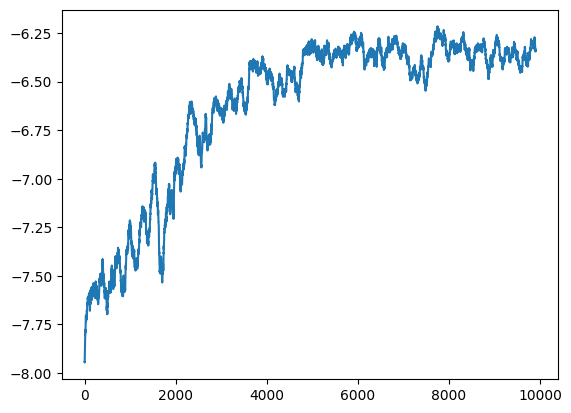

In [186]:
#plot moving average of rewards
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(rewards_per_episode, 100))

In [187]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Supongamos que ya tienes definida la clase TrafficEnv (como en el ejemplo anterior)
# y que MAX_STATE es la escala máxima (10 en este caso).

# Creamos una instancia del entorno
env = TrafficEnv()
state = env.reset()  # Estado inicial: (C1, C2)

# Configuración del plot


# Número de pasos que queremos visualizar (por ejemplo, 50 pasos)
num_steps = 50
states_trace = []
reward_trace = []

for step in range(num_steps):
    action = np.argmax(q_table, axis=2)[state[0], state[1]]
    next_state, reward, done = env.step(action)
    states_trace.append(next_state)
    reward_trace.append(reward)
    
    state = next_state

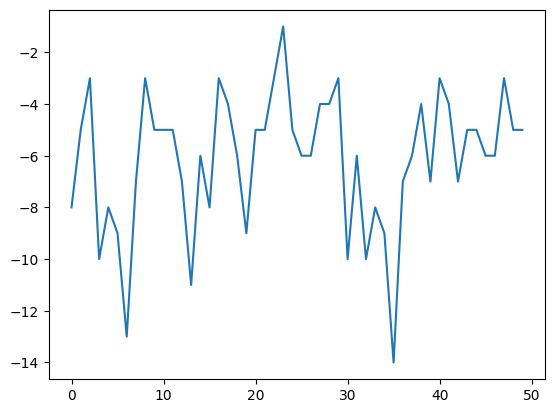

In [188]:
plt.plot(reward_trace)

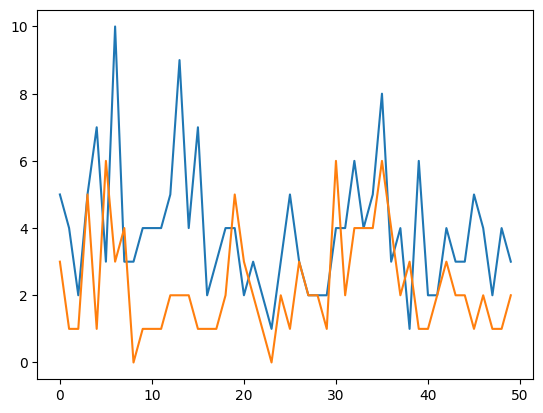

In [189]:
plt.plot([i[0] for i in states_trace])
plt.plot([i[1] for i in states_trace])

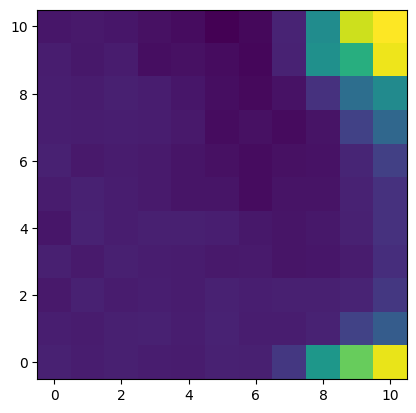

In [190]:
plt.imshow(np.max(q_table, axis=2), origin='lower')